# PandA: Concept localization

- This notebook uses the pre-trained model to demonstrate how one can localize the learnt concepts in the images, thus providing a visual understanding of the concepts encoded by these networks in the feature maps.

- In particular, this notebook localizes the "background" concept in `stylegan2_afhqdog512`

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
import tensorly as tl
import os
import numpy as np
tl.set_backend('pytorch')

from utils import plot_masks, plot_colours, mapRange
from networks.genforce.utils.visualizer import postprocess_image as postprocess

from matplotlib import pyplot as plt

import seaborn as sns
sns.set_theme()

device = torch.device('cuda')

# Build the model

- Here we load the model at layer 8, and load in the pre-trained factors to save time

In [3]:
from model import Model as Model
model_name = "stylegan2_afhqdog512"
layer = 8
M = Model(model_name, t=0, trunc_psi=1.0, device=device, layer=layer)

M.ranks = [512, 8]
pretrained = True

if pretrained:
    M.Us = torch.Tensor(np.load(f'checkpoints/Us-name_{model_name}-layer_{M.layer}-rank_{M.ranks[1]}.npy')).to(device)
    M.Uc = torch.Tensor(np.load(f'checkpoints/Uc-name_{model_name}-layer_{M.layer}-rank_{M.ranks[0]}.npy')).to(device)
else:
    # train from scratch
    M.HOSVD()
    M.decompose(lr=1e-6, ranks=M.ranks, verbose=True, log_modulo=2000, its=10000)

Building generator for model `stylegan2_afhqdog512` ...
Finish building generator.
Loading checkpoint
Finish loading checkpoint.
-- Partial Z shape at layer 8: torch.Size([1, 512, 64, 64])


## sample activations

- we sample $N$ activations here, computing the min and the max values of the coordinates throughout all samples (simply for visualisation scaling purposes), and the mean magnitude of concept of interest $k$ in these samples (for a simple mean threshold to binarize the saliency maps)
- note that $N$ here is set to a fairly arbitrary value.

In [4]:
n = 500
Zs = torch.zeros((n, M.c, M.s, M.s), device=device)
for t in range(n):
    np.random.seed(t)
    noise = torch.Tensor(np.random.randn(1, M.generator.z_space_dim)).to(M.device)
 
    Z, _ = M.sample(noise, layer=M.layer, partial=True)
    Zs[t] = Z

In [5]:
# set the appearance concept of interest
appearance = 0  # 0 corresponds to background

In [6]:
# put *all n* coordinates in terms of the appearance basis. In essence performs A^T Z_i for all n samples.
coordinates_batch = tl.tenalg.mode_dot(Zs, M.Uc.T, 1)[:, appearance, :, :].detach().cpu().numpy()
mean_concept, min_concept, max_concept = np.mean(coordinates_batch), np.min(coordinates_batch), np.max(coordinates_batch)

# Localization

With intermediate activations $\mathbf{Z}_i\in\mathbb{R}^{C \times S}$, recall that through our decomposition we have $\mathbf{A}\mathbf{A}^\top\mathbf{Z}_i\approx \mathbf{Z}_i$. We peform a *change of basis* to vizualise the coordinates w/r/t the appearance basis $\mathbf{A}$ as follows:
$$
\mathbf{A}^\top \mathbf{Z}_i,
$$
whose $k^\text{th}$ row encodes the amount of concept $k$ at each of the $S$ spatial positions in sample $i$'s feature maps.

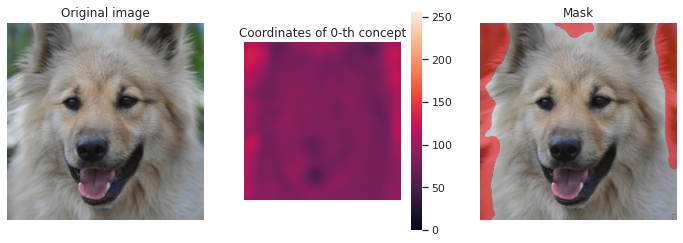

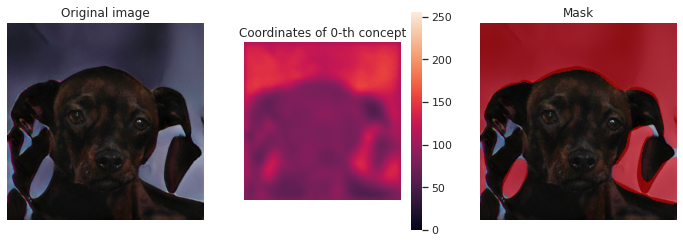

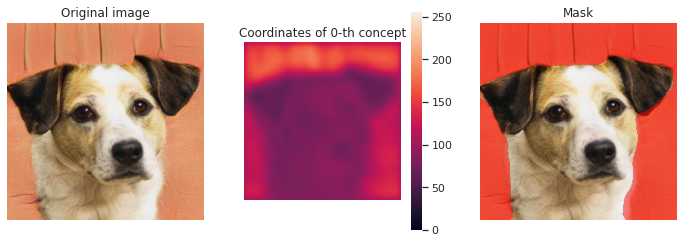

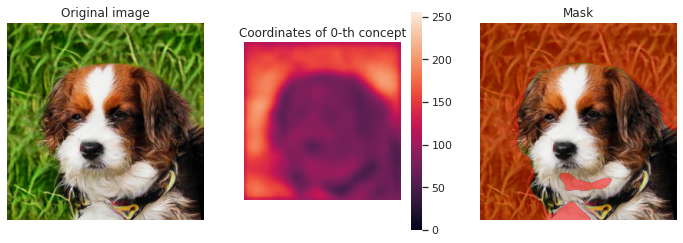

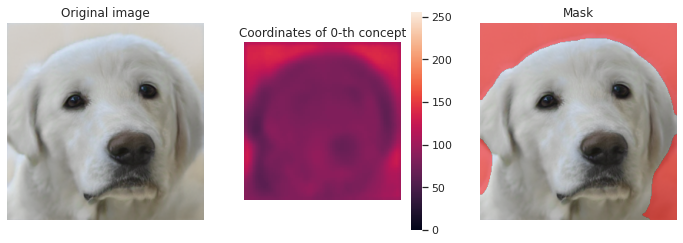

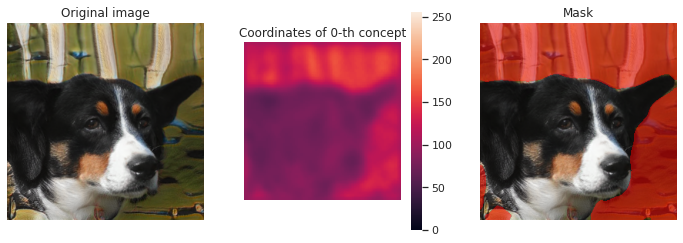

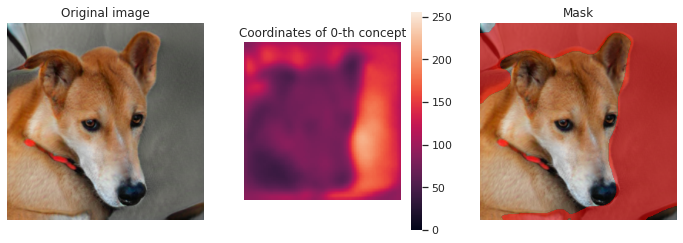

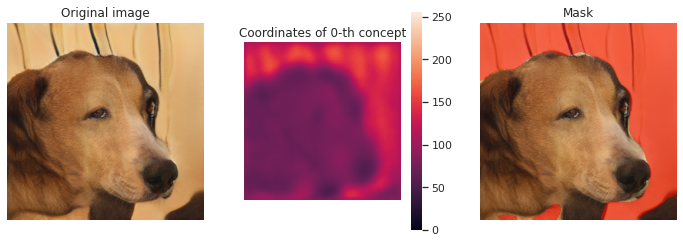

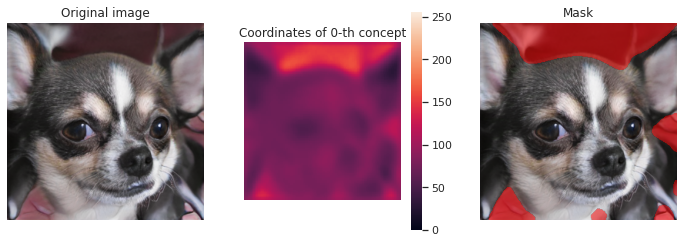

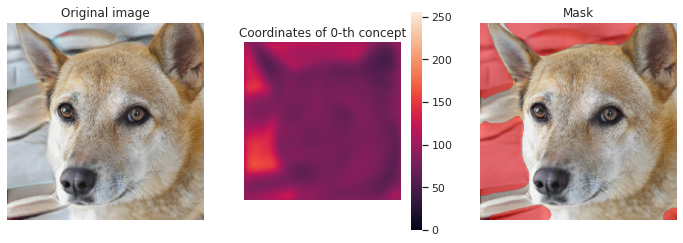

In [7]:
res_method = Image.LANCZOS

n = 10

# results in the paper sample batch size of 1k with random seed=0
np.random.seed(0)
noise_1k = torch.Tensor(np.random.randn(1000, M.generator.z_space_dim)).to(M.device)

for t in range(n):
    Z, image = M.sample(noise_1k[t:t+1], layer=M.layer)

    # change of basis
    coordinates = (M.Uc.T @ Z.view(M.c, -1))[appearance].view([M.s, M.s]).detach().cpu().numpy()

    # threshold the saliency map, too.
    mask = np.array(Image.fromarray(coordinates.squeeze()).resize((image.shape[0], image.shape[0]), res_method))[:,:,None]
    mask = (mask >= mean_concept).astype(np.uint8) * 255  # simple mean threshold
    mask = mapRange(mask, np.min(mask), np.max(mask), 0, 255).astype(np.uint8)

    color = np.array([1.0, 0.0, 0.0, 0.5])
    color_mask = (np.tile(mask, (1, 1, 4)) * color).astype(np.uint8)

    # visualise as a saliency map
    coordinates = mapRange(coordinates, min_concept, max_concept, 0, 255).astype(np.uint8)
    coordinates = np.array(Image.fromarray(coordinates).convert('L').resize((image.shape[0], image.shape[0]), res_method))[:,:,None]

    ############# plot
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

    plt.sca(axs[0])
    plt.axis('off')
    plt.imshow(image)
    plt.title('Original image')

    plt.sca(axs[1])
    ax = sns.heatmap(coordinates.squeeze(), vmin=0, vmax=255, square=True, xticklabels=False, yticklabels=False)
    plt.title(f'Coordinates of {appearance}-th concept')

    plt.sca(axs[2])
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(color_mask)
    plt.title('Mask')

    plt.show()
    ############# end plot

## Masking

- Turning the background's saliency map into a binary mask at the pixel-level, we can remove it from the image

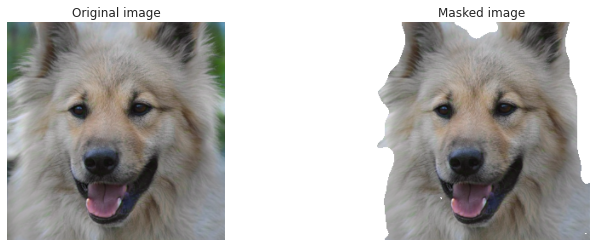

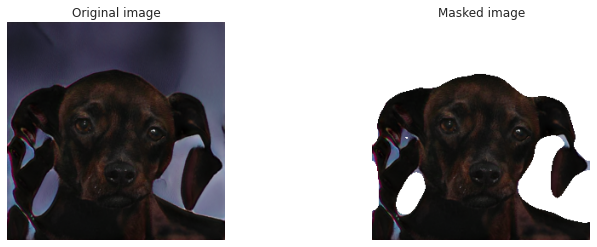

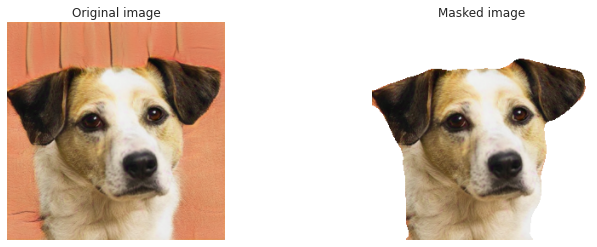

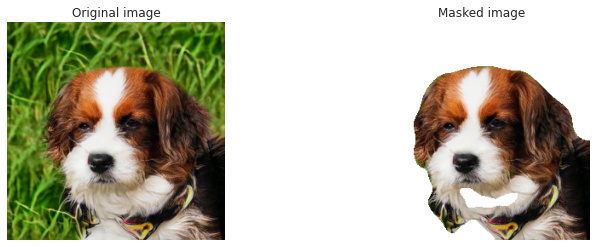

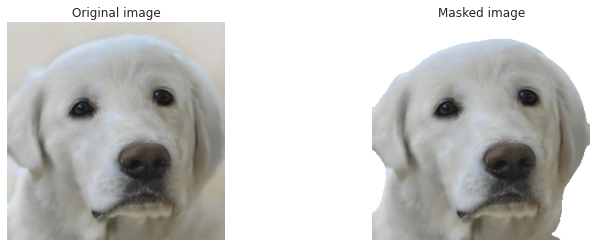

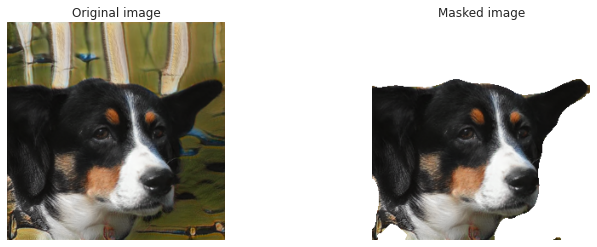

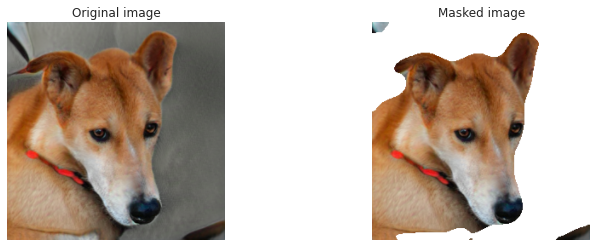

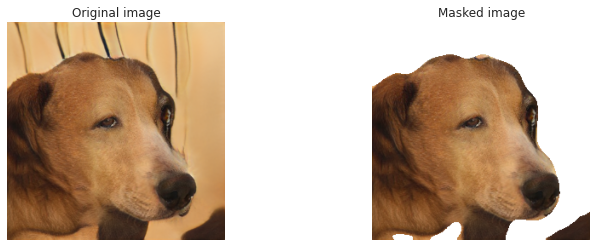

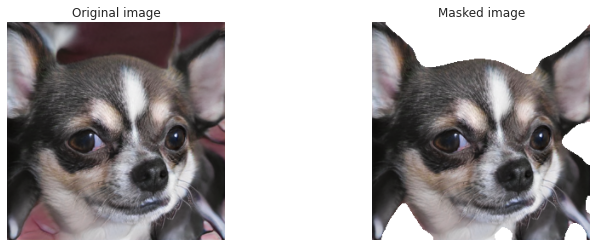

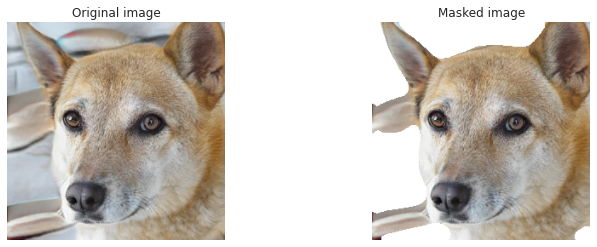

In [8]:
if appearance == 0:
    negative = True
    
    for t in range(10):
        Z, image = M.sample(noise_1k[t:t+1], layer=M.layer)

        # change of basis
        coordinates = (M.Uc.T @ Z.view(M.c, -1))[appearance].view([M.s, M.s]).detach().cpu().numpy()
        
        # threshold the saliency map, too.
        mask = np.array(Image.fromarray(coordinates.squeeze()).resize((image.shape[0], image.shape[0]), res_method))[:,:,None]
        mask = (mask >= mean_concept).astype(np.uint8) * 255  # simple mean threshold
        mask = mapRange(mask, np.min(mask), np.max(mask), 0, 255).astype(np.uint8)

        # use thresholded coordinates as mask (or negative mask)
        masked = np.where( np.invert(mask).astype(np.uint8) == 0, 255, image) if negative else np.where( mask == 0, 255, image)

        ############# plot
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

        plt.sca(axs[0])
        plt.axis('off')
        plt.imshow(image)
        plt.title('Original image')

        plt.sca(axs[1])
        plt.axis('off')
        plt.imshow(masked)
        plt.title('Masked image')
        
        plt.show()
        ############# end plot